# Exploratory Data Analys

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

from pathlib import Path

%matplotlib inline

TRAIN_PATH = 'data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data-science-bowl-2018/stage1_test/'

In [2]:
# Get train IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Read images and their masks

In [3]:
size_dataset = len(train_ids)

train_images = np.zeros(size_dataset, dtype=np.object)
train_masks = np.zeros(size_dataset, dtype=np.object)

print('Reading images and masks ... ')

img_ids= Path(TRAIN_PATH).glob('*/images/*.png')

sys.stdout.flush()
for n, img_id in tqdm(enumerate(img_ids), total=size_dataset):
    img = imread(img_id)
    # Write image to train dataset
    train_images[n] = img
    
    #Write image masks
    mask_ids = Path(str(img_id)[:-75]).glob('masks/*.png')
    mask_ids = np.array(list(mask_ids))
#     print(mask_ids[0])
    img_masks = np.zeros(len(mask_ids), dtype=np.object)
    for i, mask_id in enumerate(mask_ids):
        mask = imread(mask_id)
        img_masks[i] = mask
    train_masks[n] = img_masks
    

Reading images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:52<00:00,  5.93it/s]


## Show diffrent images

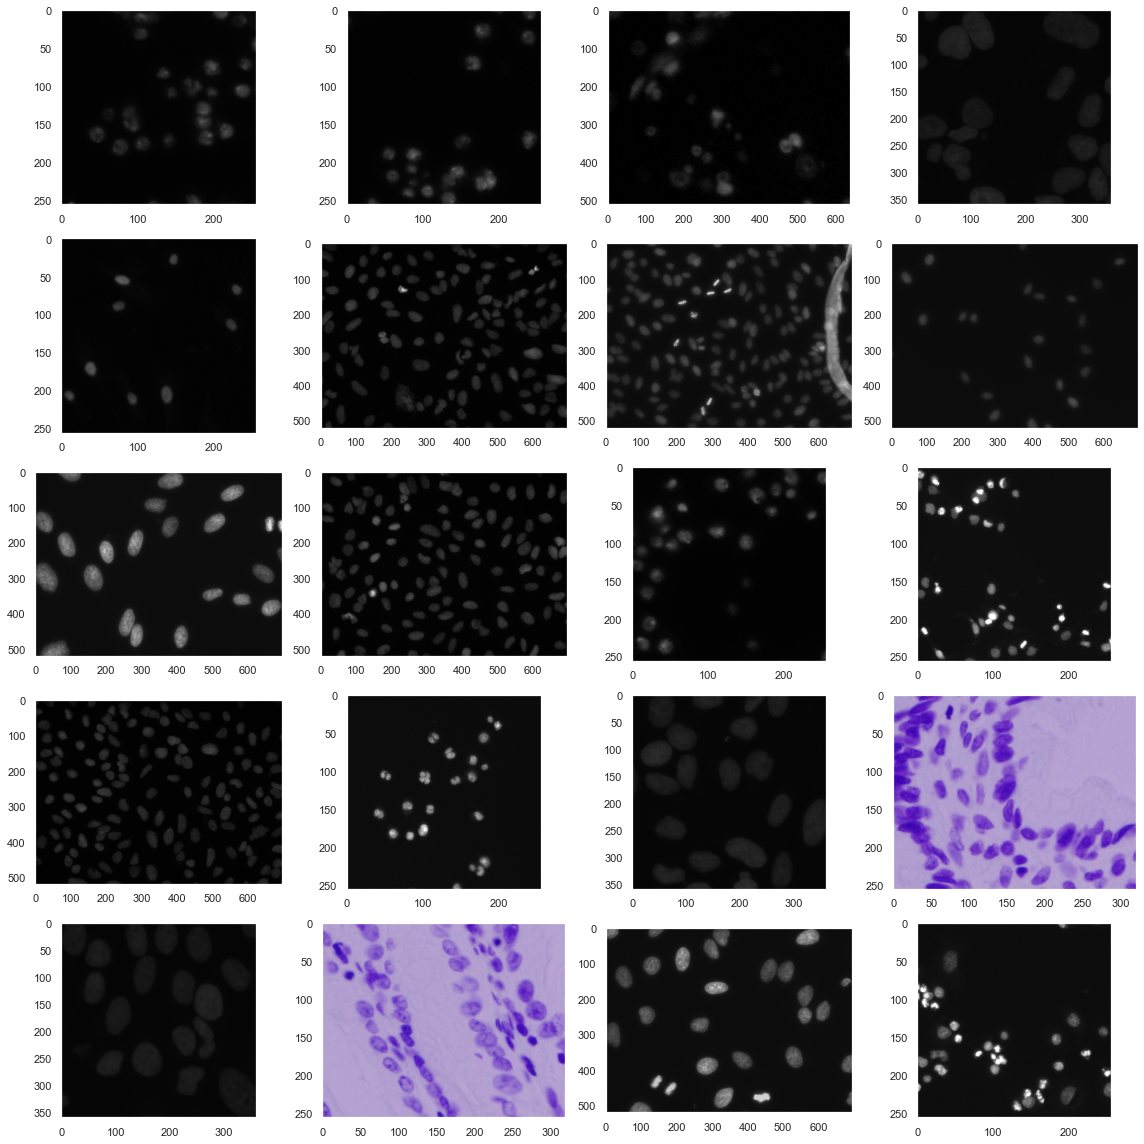

In [23]:
img_example = np.random.choice(train_images, 20)
fig, ax = plt.subplots(5, 4, figsize=(16, 16))
for i, img in enumerate(img_example):
    row = i // 4
    col = i % 4
    ax[row, col].grid(False)
    ax[row, col].imshow(img)
plt.tight_layout()

## Get metadata from images and masks

In [45]:
get_height = lambda x: x.shape[0]
get_width = lambda x: x.shape[1]
get_nuclies = lambda x: x.size

In [64]:
df_img_data = pd.DataFrame({
    'height': [get_height(i) for i in train_images],
    'width' : [get_width(i) for i in train_images],
    'nuclei' : [get_nuclies(i) for i in train_masks]
})

In [65]:
df_img_data.describe()

,height,width,nuclei
count,670.000000,670.000000,670.000000
mean,333.991045,378.500000,43.971642
std,149.474845,204.838693,47.962530
min,256.000000,256.000000,1.000000
25%,256.000000,256.000000,15.250000
50%,256.000000,320.000000,27.000000
75%,360.000000,360.000000,54.000000
max,1040.000000,1388.000000,375.000000


In [61]:
df_mask_data = pd.DataFrame(columns=['img_index', 'height', 'width', 'mask_to_img_ratio'])
for n, masks in enumerate(train_masks):
    for mask in masks:
        df_mask_data = df_mask_data.append({
            'img_index' : n,
            'height' : mask.shape[0],
            'width': mask.shape[1],
            'mask_to_img_ratio': (np.sum(mask)) / 255 / mask.shape[0] / mask.shape[1]
        }, ignore_index=True)

In [62]:
df_mask_data.describe()

,img_index,height,width,mask_to_img_ratio
count,29461.000000,29461.000000,29461.000000,29461.000000
mean,328.021724,404.408642,506.068090,0.003165
std,192.007063,187.400013,282.185678,0.004488
min,0.000000,256.000000,256.000000,0.000020
25%,168.000000,256.000000,256.000000,0.000992
50%,319.000000,360.000000,360.000000,0.001724
75%,497.000000,520.000000,696.000000,0.003376
max,669.000000,1040.000000,1388.000000,0.083557


## Show images with nuclei

### Maximum number nucleis

421


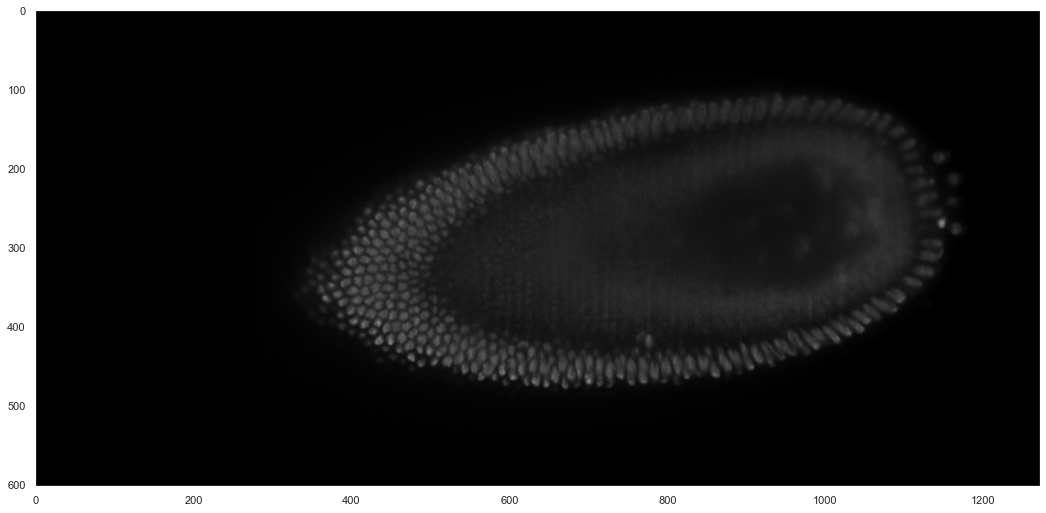

In [68]:
plt.figure(figsize=(18, 18))
much_nuclei = df_img_data['nuclei'].argmax()
print(much_nuclei)
plt.grid(None)
plt.imshow(train_images[much_nuclei]);

### Minimum number nucleis

1


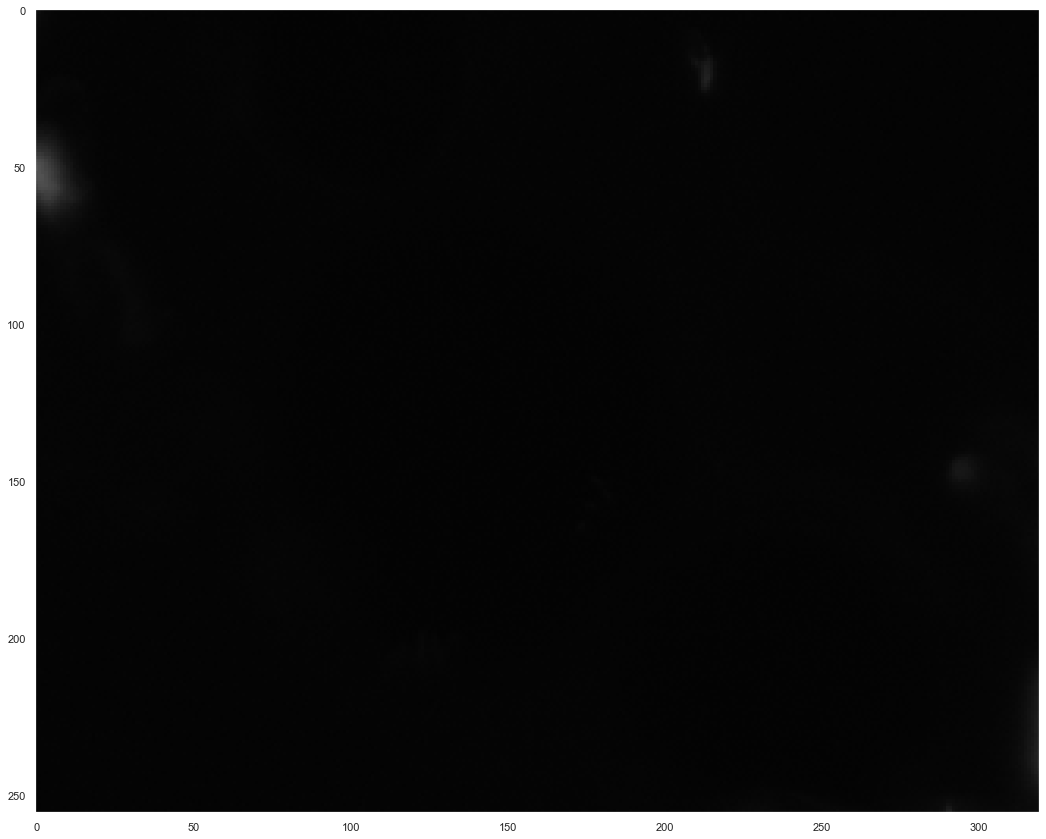

In [71]:
plt.figure(figsize=(18, 18))
not_much_nuclei = df_img_data['nuclei'].argmin()
print(df_img_data['nuclei'].min())
plt.grid(None)
plt.imshow(train_images[not_much_nuclei]);

## Nuclei sizes

### The smallest

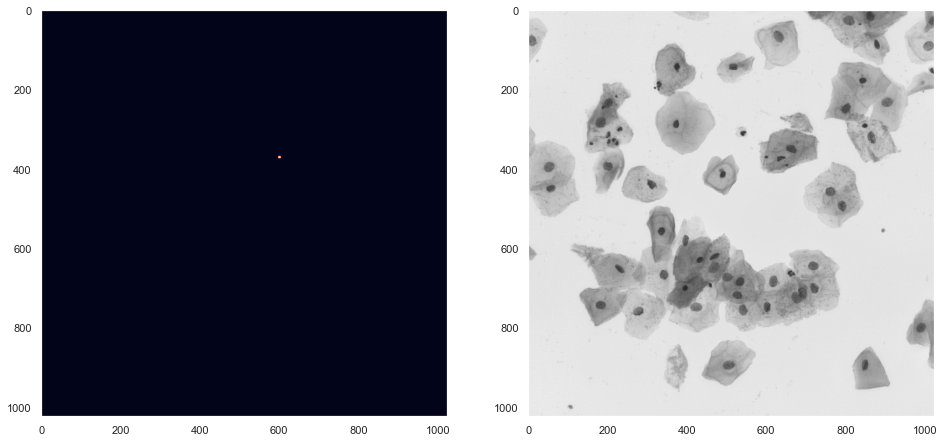

In [103]:
smallest_mask_index = df_mask_data['mask_to_img_ratio'].argmin()
img_with_nuclei = int(df_mask_data.iloc[smallest_mask_index]['img_index'])

fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].grid(None)
ax[0].imshow(train_masks[img_with_nuclei][20])
ax[1].grid(None)
ax[1].imshow(train_images[img_with_nuclei])

This nucleus is either very small or very far away! This makes me concerned about scaling down some of the larger images as some of these small nuclei could become undetectable or a least much more difficult to detect.

0.5745098039215673
2.3176470588235216
9.437254901960697


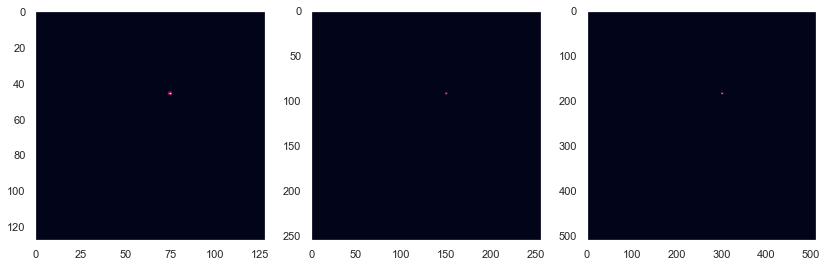

In [105]:
smallest_mask_resized_128 = resize(train_masks[img_with_nuclei][20], (128, 128))
smallest_mask_resized_256 = resize(train_masks[img_with_nuclei][20], (256, 256))
smallest_mask_resized_512 = resize(train_masks[img_with_nuclei][20], (512, 512))
print(np.sum(smallest_mask_resized_128))
print(np.sum(smallest_mask_resized_256))
print(np.sum(smallest_mask_resized_512))
fig, ax = plt.subplots(1, 3, figsize=(14, 14))
ax[0].grid(None)
ax[1].grid(None)
ax[2].grid(None)
ax[0].imshow(smallest_mask_resized_128)
ax[1].imshow(smallest_mask_resized_256)
ax[2].imshow(smallest_mask_resized_512);

### The biggest

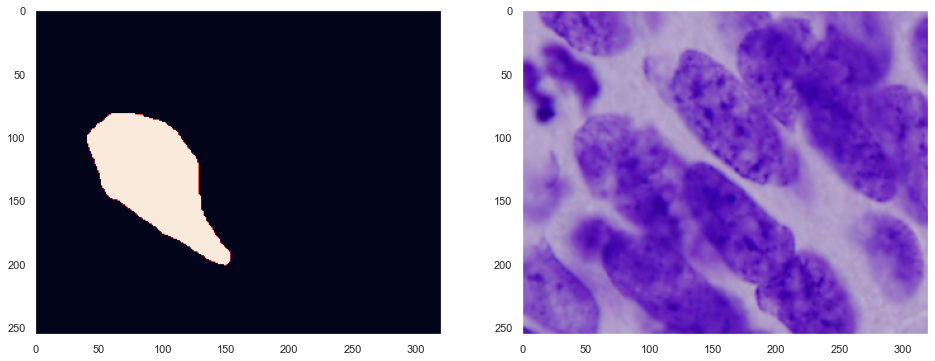

In [108]:
smallest_mask_index = df_mask_data['mask_to_img_ratio'].argmax()
img_with_nuclei = int(df_mask_data.iloc[smallest_mask_index]['img_index'])

fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].grid(None)
ax[0].imshow(train_masks[img_with_nuclei][1])
ax[1].grid(None)
ax[1].imshow(train_images[img_with_nuclei]);